### MLP on Streptococcus agalactie

In [ ]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import keras as keras
import tensorflow as tf
from keras import initializers
import scikeras
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold
from keras.optimizers.legacy import Adam
import seaborn as sns
from keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, auc, precision_recall_curve, classification_report, average_precision_score
)
from scipy.stats import zscore

print("Tensorflow version:",tf.__version__)
print("Keras version:",keras.__version__)
print("Scikeras version:",scikeras.__version__)

Tensorflow version: 2.13.0
Keras version: 2.13.1
Scikeras version: 0.11.0


In [2]:
sa = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_SA.csv')

/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_52384/1538803325.py:1: DtypeWarning: Columns (66485) have mixed types. Specify dtype option on import or set low_memory=False.
  sa = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_SA.csv')


In [3]:
# Set a seed value
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

In [27]:
# Separate feature columns and target labels
X = sa.drop(columns=['AMG',"TET","BAC","sample_ID"], errors='ignore')

X['ST'] = pd.to_numeric(X['ST'], errors='coerce')  
X = X.dropna(subset=['ST'])

# Create individual datasets per antibiotic
# Split into features and labels
sa_amg = X.copy()
sa_amg['label'] = sa['AMG']
y_amg = sa_amg['label']

sa_tet = X.copy()
sa_tet['label'] = sa['TET']
y_tet = sa_tet['label']

sa_bac = X.copy()
sa_bac['label'] = sa['BAC']
y_bac = sa_bac['label']

In [28]:
# split into 80% train+val and 20% test
X_train_amg, X_test_amg, y_train_amg, y_test_amg = train_test_split(
    X, y_amg, test_size=0.3, random_state=42, stratify=y_amg)

X_train_tet, X_test_tet, y_train_tet, y_test_tet = train_test_split(
    X, y_tet, test_size=0.3, random_state=42, stratify=y_tet)

X_train_bac, X_test_bac, y_train_bac, y_test_bac = train_test_split(
    X, y_bac, test_size=0.3, random_state=42, stratify=y_bac)

# SMOTE only on training data
smote_amg = SMOTE(random_state=42)
X_train_resampled_amg, y_train_resampled_amg = smote_amg.fit_resample(X_train_amg, y_train_amg)

smote_bac = SMOTE(random_state=42, sampling_strategy='not majority', k_neighbors=3)
X_train_resampled_bac, y_train_resampled_bac = smote_bac.fit_resample(X_train_bac, y_train_bac)

print("AMG Resampled Class Distribution:", Counter(y_train_resampled_amg))
print("BAC Resampled Class Distribution:", Counter(y_train_resampled_bac))

# X_train_resampled_* for training (70%)
# X_test_* for testing (30%)

AMG Resampled Class Distribution: Counter({0: 208, 1: 208})
BAC Resampled Class Distribution: Counter({1: 222, 0: 222})


In [17]:
# Prepare X and groups (drop ST from X, but use it for grouping)
groups_amg = X_train_resampled_amg['ST'].values
X_train_input_amg = X_train_resampled_amg.drop(columns=['ST'])
input_dim_amg = X_train_input_amg.shape[1]

# Prepare X and groups (drop ST from X, but use it for grouping)
groups_tet = X_train_tet['ST'].values
X_train_input_tet = X_train_tet.drop(columns=['ST'])
input_dim_tet = X_train_input_tet.shape[1]

# Prepare X and groups (drop ST from X, but use it for grouping)
groups_bac = X_train_resampled_bac['ST'].values
X_train_input_bac = X_train_resampled_bac.drop(columns=['ST'])
input_dim_bac = X_train_input_bac.shape[1]

### Blocked cross-validation

In [7]:
# Define parameter grid 
param_grid = {
    'model__learning_rate': [0.001, 0.0001]
    # 'model__dropout_rate': [0.5, 0.8]
}


In [8]:
# Define model-building function
def create_model(learning_rate=0.001, layer1_size=10, input_dim=input_dim_amg):
    model = Sequential()
    model.add(Dense(layer1_size, activation='sigmoid', input_shape=(input_dim,),kernel_initializer=initializers.HeNormal(seed=seed_value)))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=seed_value)))
    model.compile(optimizer= Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  weighted_metrics=['accuracy'])
    return model

##### 1. AMG

In [9]:
model_amg = KerasClassifier(model=create_model, 
                        epochs=10, 
                        verbose=0,
                        input_dim=input_dim_amg)


cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_amg, param_grid=param_grid, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_amg, y_train_resampled_amg, groups=groups_amg, verbose=0)
params_amg = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

2025-05-11 14:51:22.103710: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-11 14:51:22.103731: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-11 14:51:22.103742: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-11 14:51:22.103773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-11 14:51:22.103785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-11 14:51:22.404482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 14:51:23.871769:

Best Accuracy: 0.5994
Best Parameters: {'model__learning_rate': 0.0001}


##### 2. TET

In [29]:
model_tet = KerasClassifier(model=create_model, 
                        epochs=10, 
                        verbose=0,
                        input_dim=input_dim_tet)


cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_tet, param_grid=param_grid, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_tet, y_train_tet, groups=groups_tet, verbose=0)
params_tet = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

2025-05-11 15:21:36.329744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 15:21:37.052439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 15:21:37.519375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 15:21:38.087419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 15:21:38.559329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 15:21:39.130814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 15:21:39.622846: I tensorflow/core/grappler/optimizers/cust

Best Accuracy: 0.6055
Best Parameters: {'model__learning_rate': 0.0001}


##### 3. BAC

In [30]:
model_bac = KerasClassifier(model=create_model, 
                        epochs=100, 
                        verbose=0,
                        input_dim=input_dim_bac)


cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_bac, param_grid=param_grid, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_bac, y_train_resampled_bac, groups=groups_bac, verbose=0)
params_bac = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

2025-05-11 15:21:50.176117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 15:21:55.894932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 15:21:58.668771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 15:22:04.506691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 15:22:07.080525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 15:22:12.861388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 15:22:15.407666: I tensorflow/core/grappler/optimizers/cust

Best Accuracy: 0.8816
Best Parameters: {'model__learning_rate': 0.0001}


### Training with best hyperparameters and testing

In [39]:
def train_mlp_model(X_train, y_train, params):

    model = create_model(
        learning_rate=params['model__learning_rate'],
        #dropout_rate=params['model__dropout_rate'],
        input_dim=X_train.shape[1]
    )

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=24,
        callbacks=[early_stop],
        verbose=1,
        shuffle=False,
    )

    return model, history


In [32]:
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold=0.5, model_name=None):
    """
    Evaluates a binary classification model, compares training vs test accuracy,
    includes per-class metrics, and plots ROC and Precision-Recall curves.

    Parameters:
        model: Trained model 
        X_train, y_train: Training data (for overfitting check)
        X_test, y_test: Test data (for evaluation)
        threshold: Threshold for class prediction
    """
    # Predict probabilities
    y_test_prob = model.predict(X_test)
    y_train_prob = model.predict(X_train)

    # Flatten if needed (Keras outputs)
    if y_test_prob.ndim > 1:
        y_test_prob = y_test_prob.ravel()
    if y_train_prob.ndim > 1:
        y_train_prob = y_train_prob.ravel()

    # Apply threshold
    y_test_pred = (y_test_prob >= threshold).astype(int)
    y_train_pred = (y_train_prob >= threshold).astype(int)

    # Core metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, zero_division=0)
    rec = recall_score(y_test, y_test_pred, zero_division=0)
    f1 = f1_score(y_test, y_test_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_test_pred)
    roc_auc = auc(*roc_curve(y_test, y_test_prob)[:2])

    # Classification report (per class)
    report = classification_report(y_test, y_test_pred, target_names=["Susceptible", "Resistant"], output_dict=True)

    # Display confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix for MLP Model of {}".format(model_name))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for MLP Model of {}'.format(model_name))
    plt.grid(True)
    plt.legend()
    plt.show()

    # Compute precision-recall values
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)

    # Compute PR AUC (Average Precision)
    pr_auc = average_precision_score(y_test, y_test_prob)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for MLP Model of {}'.format(model_name))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:     {test_acc:.4f}")
    print(f"Overall Precision: {prec:.4f}")
    print(f"Overall Recall:    {rec:.4f}")
    print(f"Overall F1 Score:  {f1:.4f}")
    print(f"ROC AUC:           {roc_auc:.4f}")

    print("\nPer-Class Performance:")
    for cls in ["Susceptible", "Resistant"]:
        cls_metrics = report[cls]
        print(f"{cls:12} | Precision: {cls_metrics['precision']:.2f} | Recall: {cls_metrics['recall']:.2f} | F1: {cls_metrics['f1-score']:.2f}")
    
    print(report)


In [ ]:
# Separate feature columns and target labels
X = sa.drop(columns=['AMG',"TET","BAC","sample_ID",'ST'], errors='ignore')

# Create individual datasets per antibiotic
# Split into features and labels
sa_amg = X.copy()
sa_amg['label'] = sa['AMG']
y_amg = sa_amg['label']

sa_tet = X.copy()
sa_tet['label'] = sa['TET']
y_tet = sa_tet['label']

sa_bac = X.copy()
sa_bac['label'] = sa['BAC']
y_bac = sa_bac['label']

# split into 70% train and 30% test
X_train_amg, X_test_amg, y_train_amg, y_test_amg = train_test_split(
    X, y_amg, test_size=0.3, random_state=42, stratify=y_amg)

X_train_tet, X_test_tet, y_train_tet, y_test_tet = train_test_split(
    X, y_tet, test_size=0.3, random_state=42, stratify=y_tet)

X_train_bac, X_test_bac, y_train_bac, y_test_bac = train_test_split(
    X, y_bac, test_size=0.3, random_state=42, stratify=y_bac)

# SMOTE only on training data
smote_amg = SMOTE(random_state=42)
X_train_resampled_amg, y_train_resampled_amg = smote_amg.fit_resample(X_train_amg, y_train_amg)

smote_bac = SMOTE(random_state=42, sampling_strategy='not majority')
X_train_resampled_bac, y_train_resampled_bac = smote_bac.fit_resample(X_train_bac, y_train_bac)

print("AMG Resampled Class Distribution:", Counter(y_train_resampled_amg))
print("TET Class Distribution:", Counter(y_train_tet))
print("BAC Resampled Class Distribution:", Counter(y_train_resampled_bac))

# X_train_resampled_* for training (70%)
# X_test_* for testing (30%)

AMG Resampled Class Distribution: Counter({0: 266, 1: 266})
TET Class Distribution: Counter({0: 150, 1: 136})
BAC Resampled Class Distribution: Counter({1: 264, 0: 264})


Epoch 1/100
10/20 [==============>...............] - ETA: 0s - loss: 0.2421 - accuracy: 0.9375

2025-05-11 15:20:14.895321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 22ms/step - loss: 1.0315 - accuracy: 0.5858 - val_loss: 0.4916 - val_accuracy: 1.0000
Epoch 2/100
10/20 [==============>...............] - ETA: 0s - loss: 0.7422 - accuracy: 0.3750

2025-05-11 15:20:15.329875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 0s 7ms/step - loss: 0.6009 - accuracy: 0.6381 - val_loss: 0.4049 - val_accuracy: 0.9630
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.5065 - accuracy: 0.7845 - val_loss: 0.4456 - val_accuracy: 0.9259
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.4080 - accuracy: 0.8975 - val_loss: 0.4134 - val_accuracy: 0.9259
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 0.3710 - accuracy: 0.9038 - val_loss: 0.3992 - val_accuracy: 0.9630
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.3478 - accuracy: 0.9247 - val_loss: 0.3913 - val_accuracy: 0.9630
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.3338 - accuracy: 0.9372 - val_loss: 0.3800 - val_accuracy: 0.9630
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 0.3212 - accuracy: 0.9414 - val_loss: 0.3722 - val_accuracy: 1.0000
Epoch 9/100
20/20 [======

2025-05-11 15:20:28.636191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 4ms/step


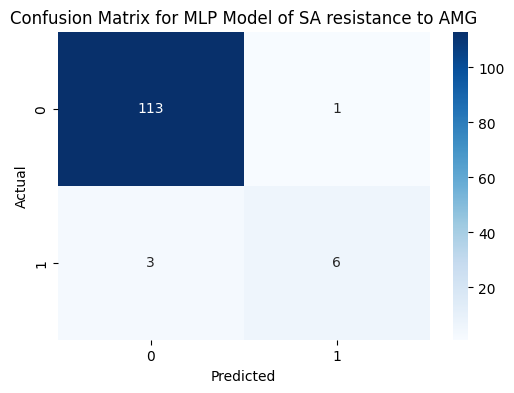

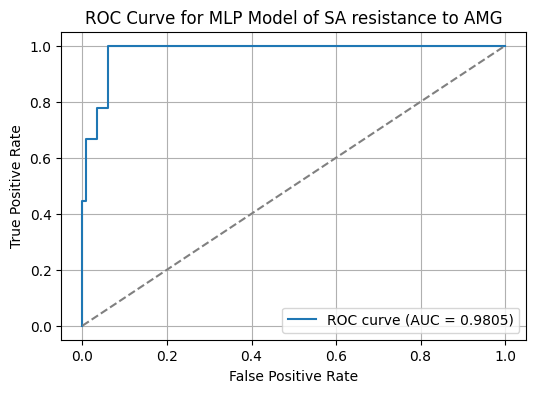

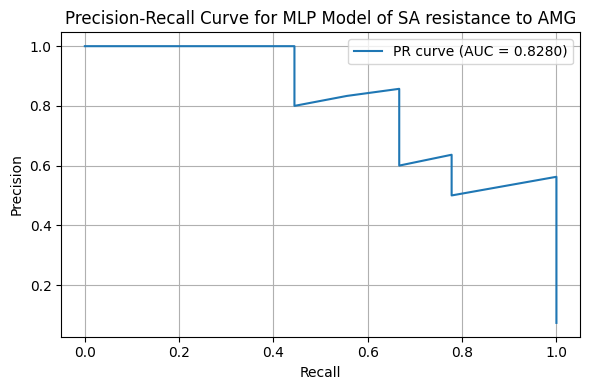

Training Accuracy: 0.9981
Test Accuracy:     0.9675
Overall Precision: 0.8571
Overall Recall:    0.6667
Overall F1 Score:  0.7500
ROC AUC:           0.9805

Per-Class Performance:
Susceptible  | Precision: 0.97 | Recall: 0.99 | F1: 0.98
Resistant    | Precision: 0.86 | Recall: 0.67 | F1: 0.75
{'Susceptible': {'precision': 0.9741379310344828, 'recall': 0.9912280701754386, 'f1-score': 0.9826086956521738, 'support': 114.0}, 'Resistant': {'precision': 0.8571428571428571, 'recall': 0.6666666666666666, 'f1-score': 0.75, 'support': 9.0}, 'accuracy': 0.967479674796748, 'macro avg': {'precision': 0.9156403940886699, 'recall': 0.8289473684210527, 'f1-score': 0.8663043478260869, 'support': 123.0}, 'weighted avg': {'precision': 0.9655773158716808, 'recall': 0.967479674796748, 'f1-score': 0.9655885471898196, 'support': 123.0}}


In [25]:
mlp_amg, _ = train_mlp_model(X_train_resampled_amg, y_train_resampled_amg, params_amg)
evaluate_model(mlp_amg, X_train_resampled_amg, y_train_resampled_amg, X_test_amg, y_test_amg, threshold=0.5, model_name="SA resistance to AMG")

##### 2. TET

Epoch 1/100
10/11 [==========================>...] - ETA: 0s - loss: 0.5558 - accuracy: 0.7000

2025-05-11 15:23:37.816793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 33ms/step - loss: 0.5593 - accuracy: 0.7004 - val_loss: 0.5692 - val_accuracy: 0.6552
Epoch 2/100
 1/11 [=>............................] - ETA: 0s - loss: 0.3854 - accuracy: 0.8333

2025-05-11 15:23:38.098623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 8ms/step - loss: 0.4651 - accuracy: 0.7782 - val_loss: 0.5066 - val_accuracy: 0.6552
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4018 - accuracy: 0.8638 - val_loss: 0.3789 - val_accuracy: 0.8966
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3604 - accuracy: 0.8949 - val_loss: 0.3442 - val_accuracy: 0.8621
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3375 - accuracy: 0.9339 - val_loss: 0.3137 - val_accuracy: 0.9310
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3204 - accuracy: 0.9455 - val_loss: 0.2925 - val_accuracy: 0.8966
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3066 - accuracy: 0.9416 - val_loss: 0.2773 - val_accuracy: 0.9310
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2957 - accuracy: 0.9455 - val_loss: 0.2693 - val_accuracy: 0.9310
Epoch 9/100
11/11 [======

2025-05-11 15:23:46.386004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


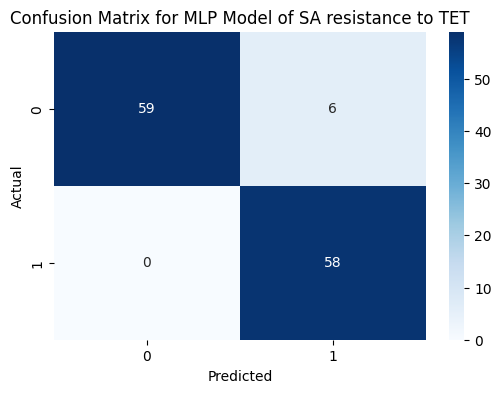

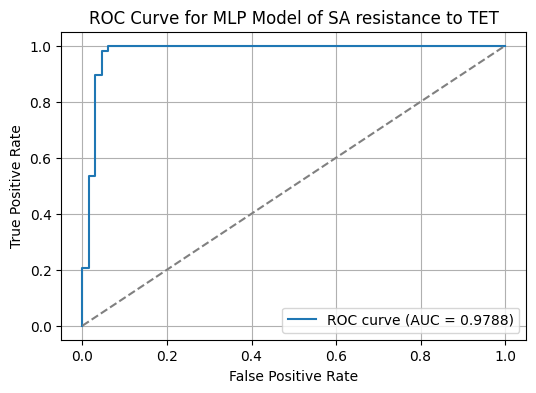

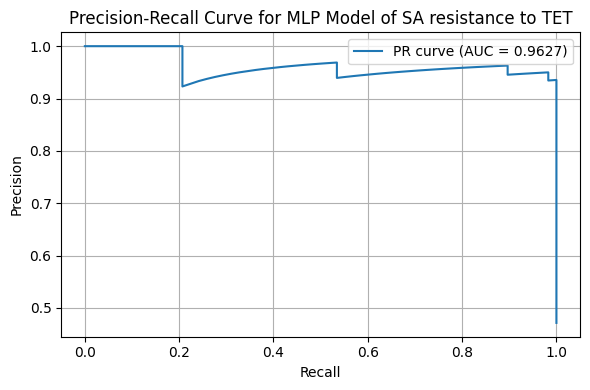

Training Accuracy: 0.9790
Test Accuracy:     0.9512
Overall Precision: 0.9062
Overall Recall:    1.0000
Overall F1 Score:  0.9508
ROC AUC:           0.9788

Per-Class Performance:
Susceptible  | Precision: 1.00 | Recall: 0.91 | F1: 0.95
Resistant    | Precision: 0.91 | Recall: 1.00 | F1: 0.95
{'Susceptible': {'precision': 1.0, 'recall': 0.9076923076923077, 'f1-score': 0.9516129032258065, 'support': 65.0}, 'Resistant': {'precision': 0.90625, 'recall': 1.0, 'f1-score': 0.9508196721311475, 'support': 58.0}, 'accuracy': 0.9512195121951219, 'macro avg': {'precision': 0.953125, 'recall': 0.9538461538461538, 'f1-score': 0.951216287678477, 'support': 123.0}, 'weighted avg': {'precision': 0.9557926829268293, 'recall': 0.9512195121951219, 'f1-score': 0.9512388592949917, 'support': 123.0}}


In [34]:
mlp_tet, _ = train_mlp_model(X_train_tet, y_train_tet, params_tet)
evaluate_model(mlp_tet, X_train_tet, y_train_tet, X_test_tet, y_test_tet, threshold=0.5, model_name="SA resistance to TET")

##### 3. BAC

In [123]:
def create_model_bac(learning_rate=0.01, input_dim=input_dim_bac):
    model = Sequential()
    model.add(Dense(20, activation='sigmoid', input_shape=(input_dim,),
                    kernel_initializer=initializers.HeNormal(seed=seed_value),
                    kernel_regularizer=keras.regularizers.l2(0.01))),
    model.add(Dense(1, activation='sigmoid',
                    kernel_initializer=keras.initializers.glorot_uniform(seed=seed_value),
                    kernel_regularizer=keras.regularizers.l2(0.01)))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def train_mlp_model_bac(X_train, y_train, params):
    model = create_model_bac(
        learning_rate=params['model__learning_rate'],
        #dropout_rate=params['model__dropout_rate'],
        input_dim=X_train.shape[1]
    )

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=24,
        callbacks=[early_stop],
        verbose=1,
        shuffle=True,
    )

    return model, history


Epoch 1/100
 1/20 [>.............................] - ETA: 4s - loss: 1.2190 - accuracy: 0.5417

2025-05-11 16:02:01.467414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 27ms/step - loss: 0.9042 - accuracy: 0.7705 - val_loss: 0.7229 - val_accuracy: 0.8491
Epoch 2/100
 7/20 [=========>....................] - ETA: 0s - loss: 0.8133 - accuracy: 0.8036

2025-05-11 16:02:02.006237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 0s 11ms/step - loss: 0.7686 - accuracy: 0.8105 - val_loss: 0.6154 - val_accuracy: 0.8491
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 0.6190 - accuracy: 0.8947 - val_loss: 0.4234 - val_accuracy: 0.9623
Epoch 4/100
20/20 [==============================] - 0s 11ms/step - loss: 0.5059 - accuracy: 0.9326 - val_loss: 0.4578 - val_accuracy: 0.9623
Epoch 5/100
20/20 [==============================] - 0s 11ms/step - loss: 0.4484 - accuracy: 0.9495 - val_loss: 0.3394 - val_accuracy: 0.9623
Epoch 6/100
20/20 [==============================] - 0s 11ms/step - loss: 0.4070 - accuracy: 0.9474 - val_loss: 0.2841 - val_accuracy: 0.9623
Epoch 7/100
20/20 [==============================] - 0s 12ms/step - loss: 0.3799 - accuracy: 0.9558 - val_loss: 0.2542 - val_accuracy: 0.9623
Epoch 8/100
20/20 [==============================] - 0s 11ms/step - loss: 0.3648 - accuracy: 0.9516 - val_loss: 0.3990 - val_accuracy: 0.9623
Epoch 9/100
20/20 

2025-05-11 16:02:19.190989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 4ms/step


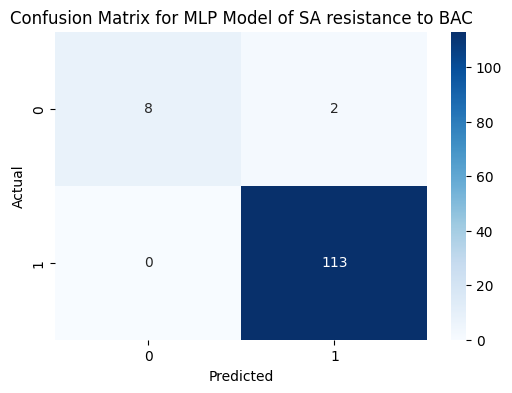

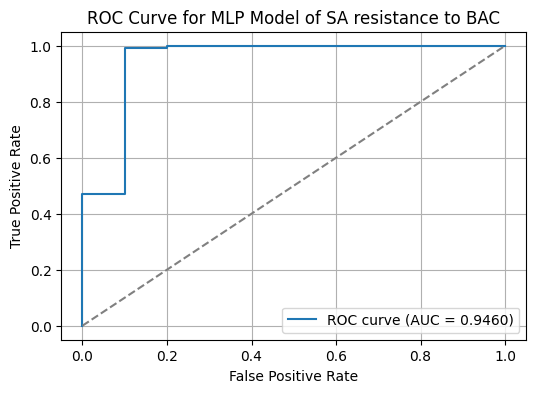

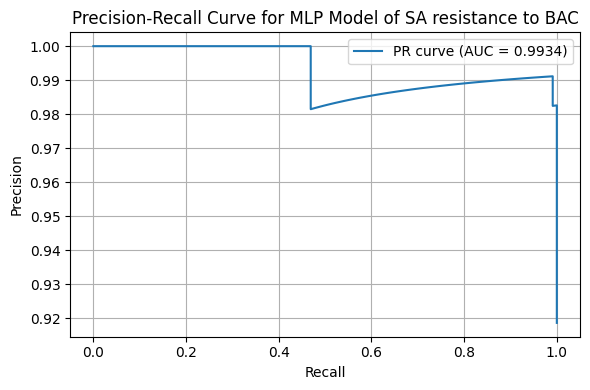

Training Accuracy: 0.9981
Test Accuracy:     0.9837
Overall Precision: 0.9826
Overall Recall:    1.0000
Overall F1 Score:  0.9912
ROC AUC:           0.9460

Per-Class Performance:
Susceptible  | Precision: 1.00 | Recall: 0.80 | F1: 0.89
Resistant    | Precision: 0.98 | Recall: 1.00 | F1: 0.99
{'Susceptible': {'precision': 1.0, 'recall': 0.8, 'f1-score': 0.888888888888889, 'support': 10.0}, 'Resistant': {'precision': 0.9826086956521739, 'recall': 1.0, 'f1-score': 0.9912280701754386, 'support': 113.0}, 'accuracy': 0.983739837398374, 'macro avg': {'precision': 0.991304347826087, 'recall': 0.9, 'f1-score': 0.9400584795321638, 'support': 123.0}, 'weighted avg': {'precision': 0.984022622834924, 'recall': 0.983739837398374, 'f1-score': 0.9829078115342557, 'support': 123.0}}


In [124]:
mlp_bac, _ = train_mlp_model_bac(X_train_resampled_bac, y_train_resampled_bac, params_bac)
evaluate_model(mlp_bac, X_train_resampled_bac, y_train_resampled_bac, X_test_bac, y_test_bac, threshold=0.3, model_name="SA resistance to BAC")

### Feature importance

In [131]:
def get_top_outliers(model, X_train):
    #keras_model = mlp_tmp.model()
    weights = [layer.get_weights()[0] for layer in model.layers if isinstance(layer, keras.layers.Dense)]

    # Flatten the weights into a single vector
    flattened_weights = np.concatenate([w.flatten() for w in weights])

    # Compute Z-scores for the flattened weights
    z_scores = zscore(flattened_weights)

    # Identify outliers (e.g., Z-score > 3 or Z-score < -3 are considered outliers)
    outliers = np.where(np.abs(z_scores) > 3)[0]  # Indices of outliers
    print("Outlier indices based on Z-scores:", outliers)

    # Get the absolute values of the outlier weights
    outlier_weights = np.abs(flattened_weights[outliers])

    # Rank the outliers based on their absolute weight values (highest first)
    top_20_outlier_indices = outliers[np.argsort(outlier_weights)[-20:][::-1]]

    print("Top 20 outlier indices:", top_20_outlier_indices)

    # For the first layer, map outlier indices to input features
    first_layer_weights = weights[0]  # The weights of the first layer

    # Map the top 20 outlier indices to input feature indices
    input_feature_indices = top_20_outlier_indices % first_layer_weights.shape[0]

    print("Top 20 outlier features (input feature indices):", input_feature_indices)

    # Display the top 20 outlier features and their corresponding weights
    top_20_outlier_weights = flattened_weights[top_20_outlier_indices]
    print("Top 20 Outlier Features and Their Corresponding Weights:")
    for i, idx in enumerate(top_20_outlier_indices):
        print(f"Feature {input_feature_indices[i]}: Weight = {top_20_outlier_weights[i]}")


    # Get the column names (feature names)
    feature_names = X_train.columns

    # Map the top 20 outlier indices to the corresponding feature names
    top_20_feature_names = feature_names[input_feature_indices]  # input_feature_indices is from previous steps

    print("Top 20 outlier feature names:", top_20_feature_names)

    return top_20_feature_names, top_20_outlier_weights




In [127]:
def visualize_outliers(top_20_feature_names, top_20_outlier_weights, drug_name):

    # Set figure size for better readability
    plt.figure(figsize=(14, 7))

    # Separate positive and negative weights
    positive_weights = top_20_outlier_weights[top_20_outlier_weights > 0]
    negative_weights = top_20_outlier_weights[top_20_outlier_weights < 0]

    # Define color maps for positive (red) and negative (blue) weights
    positive_colors = plt.cm.Reds(np.linspace(0, 1, len(positive_weights)))  # Reds for positive weights
    negative_colors = plt.cm.Blues(np.linspace(0, 1, len(negative_weights)))  # Blues for negative weights

    # Plot bars for positive and negative weights
    bars_positive = plt.barh(range(len(positive_weights)), positive_weights, color=positive_colors)
    bars_negative = plt.barh(range(len(positive_weights), len(positive_weights) + len(negative_weights)), 
                            negative_weights, color=negative_colors)

    # Add feature names as y-ticks for both positive and negative bars
    plt.yticks(range(len(top_20_feature_names)), top_20_feature_names, fontsize=10)

    # Add titles and labels with a larger font size
    plt.title('Top 20 Outlier Features\n(MLP - SA Resistance to {})'.format(drug_name))
    plt.xlabel('Outlier Weight Value', fontsize=12)
    plt.ylabel('Feature Name', fontsize=12)

    # Optionally, add gridlines to make it easier to read the x-values
    plt.grid(axis='x', linestyle='--', alpha=0.7)


    # Adjust layout to ensure everything fits properly
    plt.tight_layout()

    # Show the plot
    plt.show()


##### 1. AMG

Outlier indices based on Z-scores: [ 16301  16321  17371 ... 664817 664818 664819]
Top 20 outlier indices: [664813 664819 664814 664818 664817 664816 664812 664810 664815  24551
  43826  44801  34151  45651 281311  43096  32351  45516  30931 343276]
Top 20 outlier features (input feature indices): [    3     9     4     8     7     6     2     0     5 24551 43826 44801
 34151 45651 15387 43096 32351 45516 30931 10871]
Top 20 Outlier Features and Their Corresponding Weights:
Feature 3: Weight = -0.768570601940155
Feature 9: Weight = -0.7149735689163208
Feature 4: Weight = -0.6865541934967041
Feature 8: Weight = -0.6071548461914062
Feature 7: Weight = -0.5476276278495789
Feature 6: Weight = 0.47032180428504944
Feature 2: Weight = 0.42637214064598083
Feature 0: Weight = -0.38601675629615784
Feature 5: Weight = 0.28868532180786133
Feature 24551: Weight = 0.08597202599048615
Feature 43826: Weight = -0.08466638624668121
Feature 44801: Weight = -0.08217753469944
Feature 34151: Weight = 0.0815

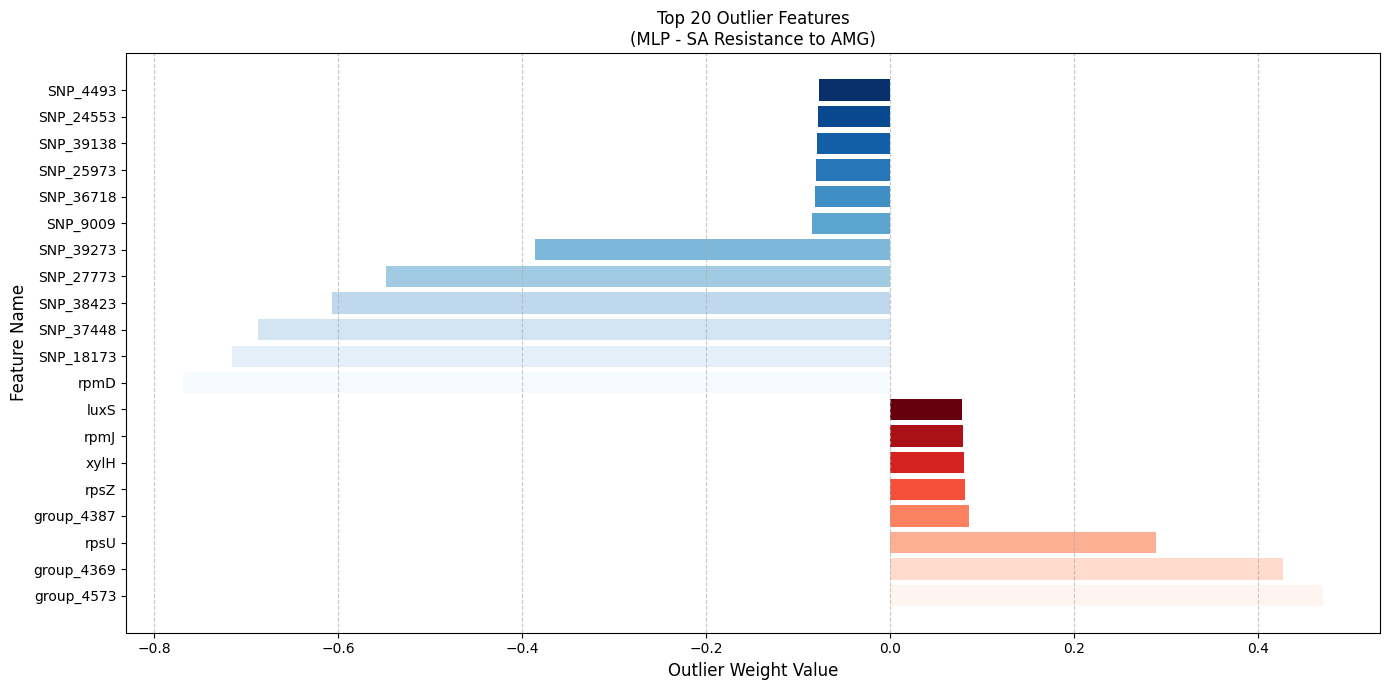

In [132]:
feature_names_amg, outlier_weights_amg = get_top_outliers(mlp_amg, X_train_resampled_amg)
visualize_outliers(feature_names_amg, outlier_weights_amg, drug_name="AMG")

##### 2. TET

Outlier indices based on Z-scores: [ 17341  17441  17491 ... 664817 664818 664819]
Top 20 outlier indices: [664813 664819 664814 664818 664817 664816 664812 664810 664815 664811
  19321  19281  19311  19331  19271  18971  19231  19251  19441  18981]
Top 20 outlier features (input feature indices): [    3     9     4     8     7     6     2     0     5     1 19321 19281
 19311 19331 19271 18971 19231 19251 19441 18981]
Top 20 Outlier Features and Their Corresponding Weights:
Feature 3: Weight = -0.7991763949394226
Feature 9: Weight = -0.744788408279419
Feature 4: Weight = -0.7008978724479675
Feature 8: Weight = -0.627494752407074
Feature 7: Weight = -0.5636641979217529
Feature 6: Weight = 0.47851112484931946
Feature 2: Weight = 0.420149028301239
Feature 0: Weight = -0.41186976432800293
Feature 5: Weight = 0.28917279839515686
Feature 1: Weight = -0.09691932052373886
Feature 19321: Weight = -0.07922619581222534
Feature 19281: Weight = -0.07791304588317871
Feature 19311: Weight = -0.075182

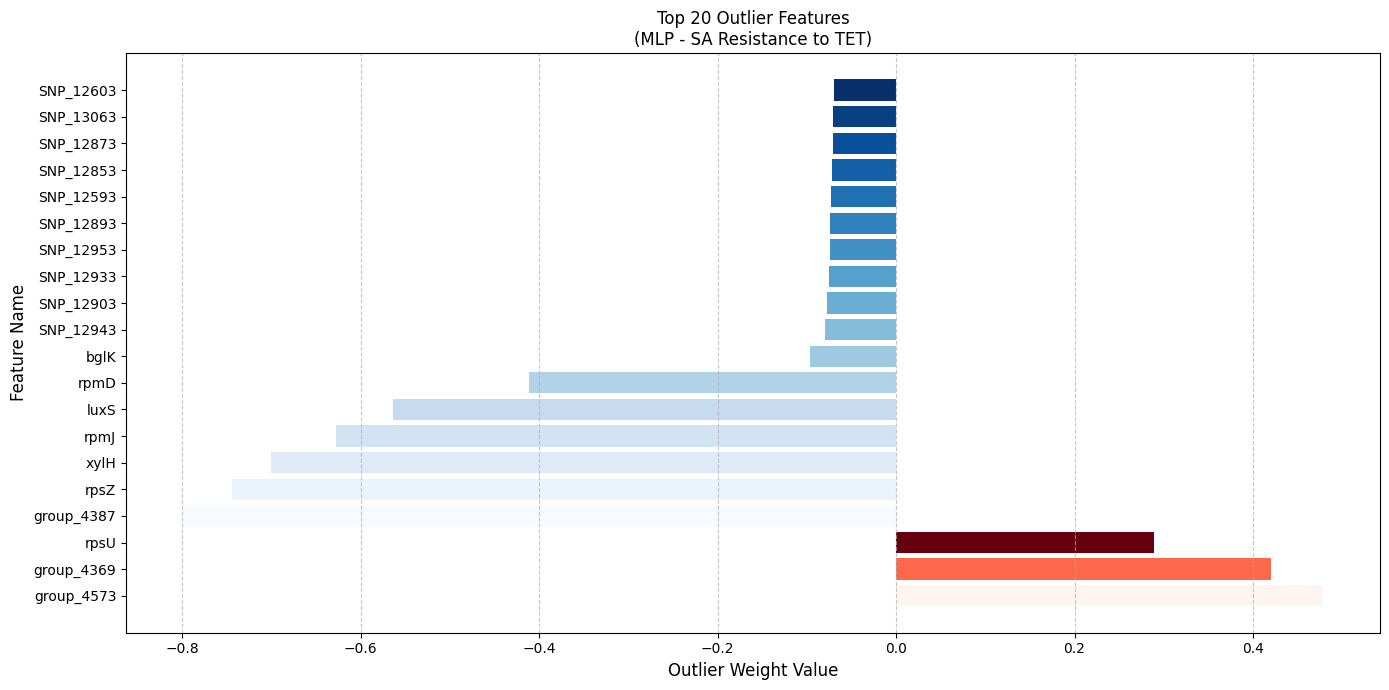

In [133]:
feature_names_tet, outlier_weights_tet = get_top_outliers(mlp_tet, X_train_tet)
visualize_outliers(feature_names_tet, outlier_weights_tet, drug_name="TET")

##### 3. BAC

Outlier indices based on Z-scores: [    303    5830    6803 ... 1329637 1329638 1329639]
Top 20 outlier indices: [1329630 1329623 1329629 1329624 1329628 1329637 1329627 1329635 1329626
 1329639 1329634 1329631 1329622 1329633 1329620 1329625 1329636 1329621
 1329638  389270]
Top 20 outlier features (input feature indices): [   10     3     9     4     8    17     7    15     6    19    14    11
     2    13     0     5    16     1    18 56865]
Top 20 Outlier Features and Their Corresponding Weights:
Feature 10: Weight = 0.5664215683937073
Feature 3: Weight = -0.5441551804542542
Feature 9: Weight = -0.5124184489250183
Feature 4: Weight = -0.48996710777282715
Feature 8: Weight = -0.4366840124130249
Feature 17: Weight = -0.3981721103191376
Feature 7: Weight = -0.3896239995956421
Feature 15: Weight = 0.38115474581718445
Feature 6: Weight = 0.3660532832145691
Feature 19: Weight = -0.3635452389717102
Feature 14: Weight = 0.3322618305683136
Feature 11: Weight = -0.33036836981773376
Feature 2

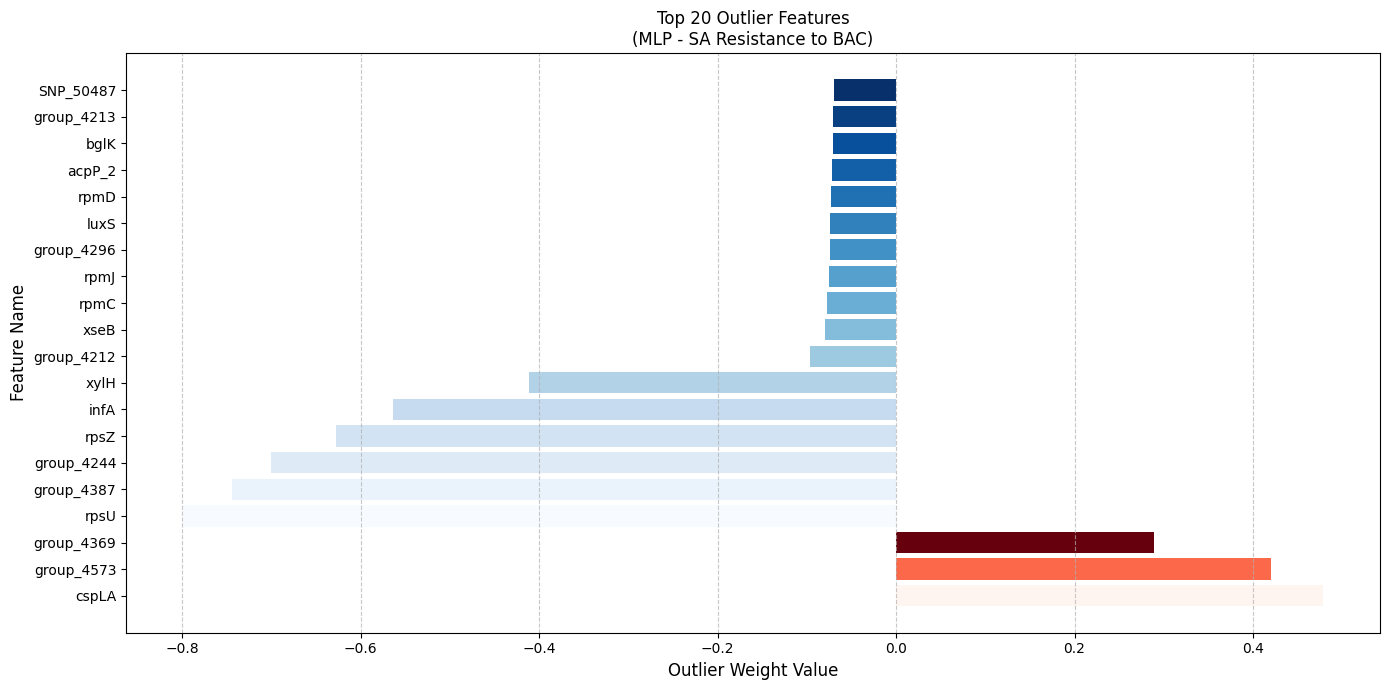

In [134]:
feature_names_bac, outlier_weights_bac = get_top_outliers(mlp_bac, X_train_resampled_bac)
visualize_outliers(feature_names_bac, outlier_weights_tet, drug_name="BAC")